In [33]:
import requests
import os
import pandas as pd
import datetime
import time
from itertools import islice
import matplotlib.pyplot as plt

CLIENT_ID = os.environ["SPOTIFY_CLIENT_ID"]
CLIENT_SECRET = os.environ["SPOTIFY_CLIENT_SECRET"]

In [26]:
# Token holen
header = {"Content-Type": "application/x-www-form-urlencoded"}
data = f"grant_type=client_credentials&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}"
resp = requests.post("https://accounts.spotify.com/api/token", headers=header, data=data)
resp.raise_for_status()
token = resp.json()["access_token"]

session = requests.Session()
session.headers.update({"Authorization": f"Bearer {token}"})

In [27]:
def request_json(method, url, **kwargs):
    """Requests mit 429-Handling (Retry-After)."""
    while True:
        r = session.request(method, url, **kwargs)
        if r.status_code == 429:
            wait = int(r.headers.get("Retry-After", "1"))
            time.sleep(wait)
            continue
        r.raise_for_status()
        return r.json()

def chunked(iterable, size):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, size))
        if not chunk:
            return
        yield chunk

# paginate new releases 
def get_all_new_releases(market, limit=50, max_total=None):
    url = "https://api.spotify.com/v1/browse/new-releases"
    params = {"limit": limit, "offset": 0}
    if market:
        params["market"] = market

    albums_all = []

    # first page
    page = request_json("GET", url, params=params)
    albums = page["albums"]
    albums_all.extend(albums["items"])

    total = albums.get("total", len(albums_all))
    next_url = albums.get("next")

    # optional cap
    target_total = min(max_total, total) if max_total is not None else total

    # follow 'next' until None
    while next_url and len(albums_all) < target_total:
        page = request_json("GET", next_url)
        albums = page["albums"]
        albums_all.extend(albums["items"])
        next_url = albums.get("next")

    # trim to max_total if requested
    if max_total is not None and len(albums_all) > max_total:
        albums_all = albums_all[:max_total]

    return albums_all


# paginate album tracks
def get_all_album_tracks(album_id, market="AT", limit=50):
    url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
    params = {"limit": limit, "offset": 0}
    if market:
        params["market"] = market

    tracks_all = []
    page = request_json("GET", url, params=params)
    tracks_all.extend(page.get("items", []))
    next_url = page.get("next")

    while next_url:
        page = request_json("GET", next_url)
        tracks_all.extend(page.get("items", []))
        next_url = page.get("next")

    return tracks_all


def get_tracks_details(track_ids, market="AT"):
    details = {}
    for chunk in chunked(track_ids, 50):
        params = {"ids": ",".join(chunk)}
        if market:
            params["market"] = market
        data = request_json("GET", "https://api.spotify.com/v1/tracks", params=params)
        for t in data.get("tracks", []):
            if t:
                details[t["id"]] = {
                    "name": t["name"],
                    "duration_ms": t["duration_ms"],
                    "popularity": t.get("popularity"),
                }
    return details

In [28]:
market = "AT"
all_albums = get_all_new_releases(market=market, limit=50)
rows = []
all_track_ids = []


In [29]:
len(all_albums)

100

In [30]:
for album in all_albums:
    album_id = album["id"]
    album_name = album["name"]
    artists = ", ".join(a["name"] for a in album.get("artists", []))

    album_meta = {
        "album_id": album_id,
        "album_name": album_name,
        "album_artists": artists,
        "album_total_tracks": album.get("total_tracks"),
        "album_release_date": album.get("release_date"),
        "album_release_date_precision": album.get("release_date_precision"),
    }

    tracks = get_all_album_tracks(album_id, market=market, limit=50)

    for t in tracks:
        tid = t.get("id")
        if not tid:
            continue

        rows.append({
            **album_meta,
            "track_id": tid,
            "track_name": t.get("name"),
            "track_number": t.get("track_number"),
            "track_duration_ms": t.get("duration_ms"),
        })
        all_track_ids.append(tid)

details_map = get_tracks_details(all_track_ids, market=market)
for r in rows:
    d = details_map.get(r["track_id"])
    if d:
        r["track_popularity"] = d["popularity"]
        r["track_duration_ms"] = d["duration_ms"] or r["track_duration_ms"]
        r["track_name"] = d["name"] or r["track_name"]

df = pd.DataFrame(rows)
df

,album_id,album_name,album_artists,album_total_tracks,album_release_date,album_release_date_precision,track_id,track_name,track_number,track_duration_ms,track_popularity
0,3KEouIGOcu6aaTAC94W1Sv,I Hope You Heal,Catapults,12,2025-09-19,day,1cMVTK4br07VVK1u6RshJy,W.L.W.,1,180190,20
1,3KEouIGOcu6aaTAC94W1Sv,I Hope You Heal,Catapults,12,2025-09-19,day,3f5lLuSuN0dFg6QVOojuun,Half King,2,235000,20
2,3KEouIGOcu6aaTAC94W1Sv,I Hope You Heal,Catapults,12,2025-09-19,day,1zQ00Dm1DwXjjtrLLzkm1u,Digging Deeper/Going Nowhere,3,196000,19
3,3KEouIGOcu6aaTAC94W1Sv,I Hope You Heal,Catapults,12,2025-09-19,day,5m6ewMDwBow6WoYPYVbDu7,A-Okay - 2025 Version,4,202000,19
4,3KEouIGOcu6aaTAC94W1Sv,I Hope You Heal,Catapults,12,2025-09-19,day,00vRtnEjSjdI2HIcMeaSUB,Wasever,5,206000,18
...,...,...,...,...,...,...,...,...,...,...,...
1370,1WWC30whzWg114IF0EEcRx,Smurfs Movie Soundtrack (Music From & Inspired...,Smurfs Cast,14,2025-06-13,day,0YEaeKIzMVox9wMKoojzPO,Balle Balouza - from the Smurfs Movie Soundtrack,10,211076,27
1371,1WWC30whzWg114IF0EEcRx,Smurfs Movie Soundtrack (Music From & Inspired...,Smurfs Cast,14,2025-06-13,day,0cGevwqB5N1trB66N4x2DB,Everything Goes With Blue - from the Smurfs Mo...,11,130192,51
1372,1WWC30whzWg114IF0EEcRx,Smurfs Movie Soundtrack (Music From & Inspired...,Smurfs Cast,14,2025-06-13,day,5V6yBr5YpakmcNNQTGKcEr,It’s My Party - from the Smurfs Movie Soundtrack,12,158319,37
1373,1WWC30whzWg114IF0EEcRx,Smurfs Movie Soundtrack (Music From & Inspired...,Smurfs Cast,14,2025-06-13,day,0Vq9aQMmJ8tcWIB2syCsUG,Always On The Outside - from the Smurfs Movie ...,13,200217,35


In [31]:
today = str(datetime.date.today())
df.to_excel(f"new_releases_{today}.xlsx", sheet_name=today, index=False)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   album_id                      1375 non-null   object
 1   album_name                    1375 non-null   object
 2   album_artists                 1375 non-null   object
 3   album_total_tracks            1375 non-null   int64 
 4   album_release_date            1375 non-null   object
 5   album_release_date_precision  1375 non-null   object
 6   track_id                      1375 non-null   object
 7   track_name                    1375 non-null   object
 8   track_number                  1375 non-null   int64 
 9   track_duration_ms             1375 non-null   int64 
 10  track_popularity              1375 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 118.3+ KB


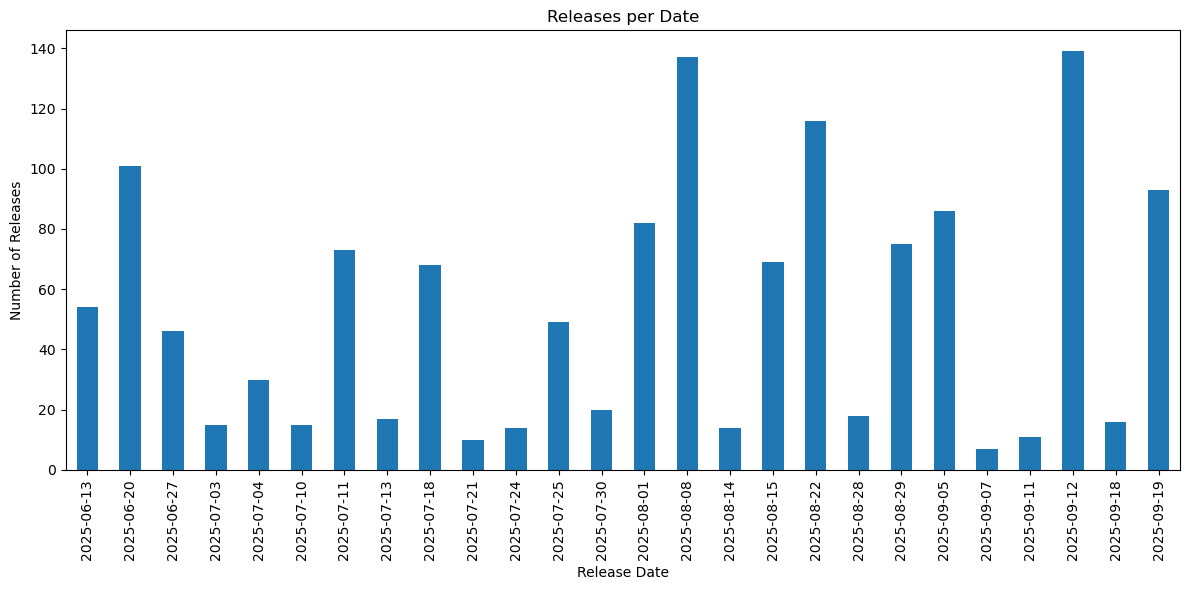

In [ ]:
## RELEASES PRO DATUM

df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')

releases_per_date = df.groupby(df['album_release_date'].dt.date).size()

plt.figure(figsize=(12,6))
releases_per_date.plot(kind='bar')
plt.xlabel("Release Date")
plt.ylabel("Number of Releases")
plt.title("Releases per Date")
plt.tight_layout()
plt.show()

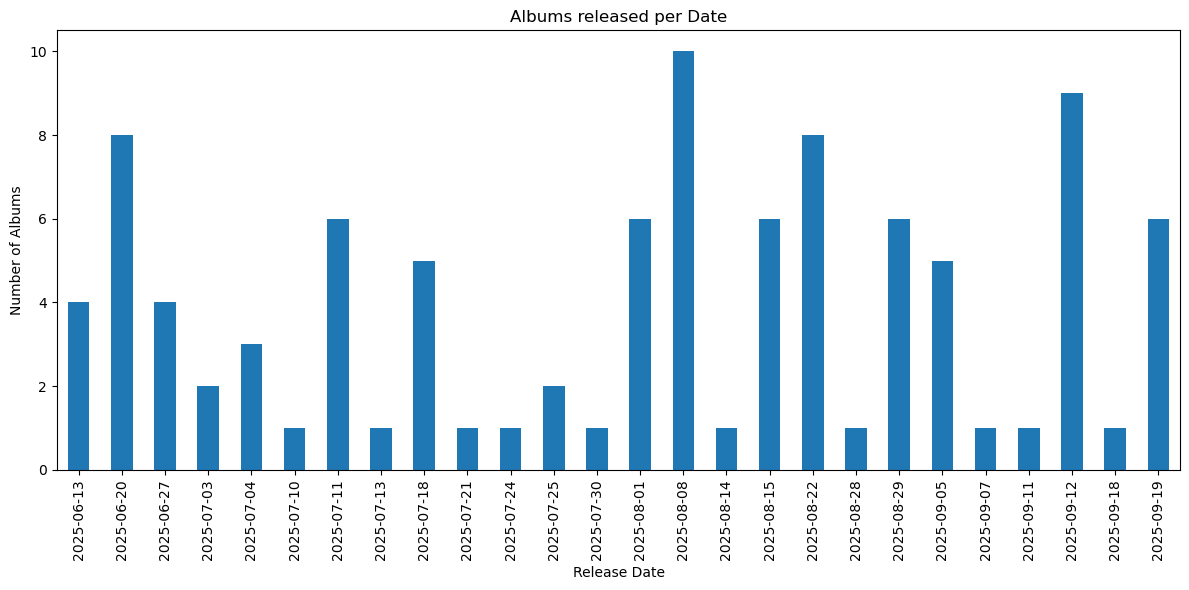

In [ ]:
## ALBEN PRO DATUM
albums_per_date = df.drop_duplicates(subset=["album_id"]).groupby(
    pd.to_datetime(df['album_release_date'], errors='coerce').dt.date
).size()

plt.figure(figsize=(12,6))
albums_per_date.plot(kind='bar')
plt.xlabel("Release Date")
plt.ylabel("Number of Albums")
plt.title("Albums released per Date")
plt.tight_layout()
plt.show()

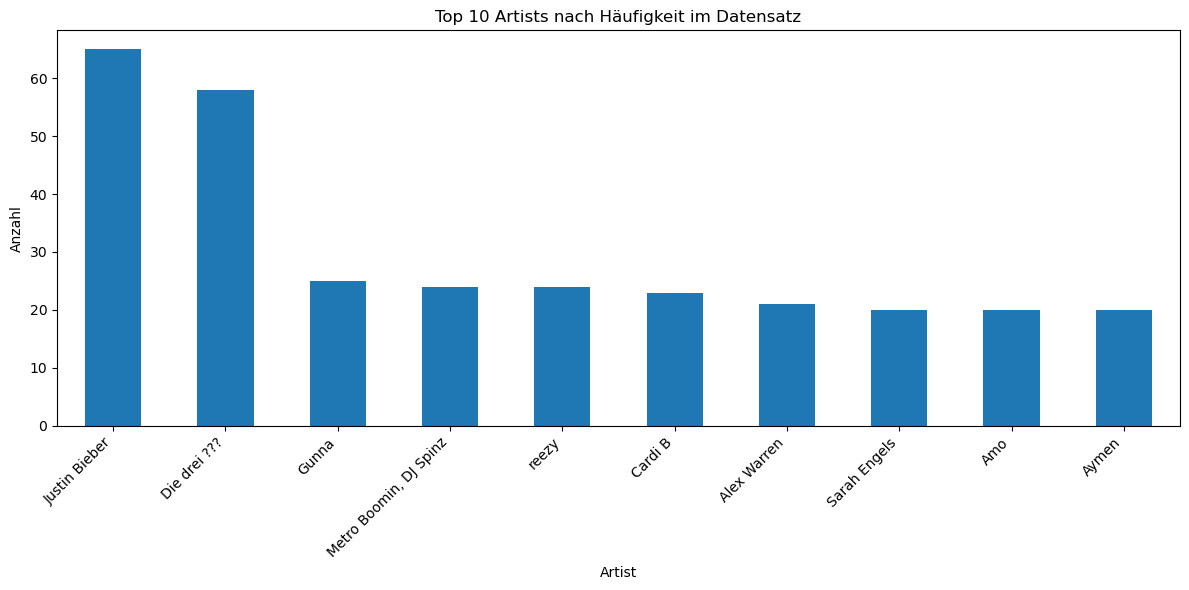

In [36]:
## ARTISTS NACH HÄUFIGKEIT
artist_counts = df['album_artists'].value_counts()

plt.figure(figsize=(12,6))
artist_counts.head(10).plot(kind='bar')
plt.xlabel("Artist")
plt.ylabel("Anzahl")
plt.title("Top 10 Artists nach Häufigkeit im Datensatz")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

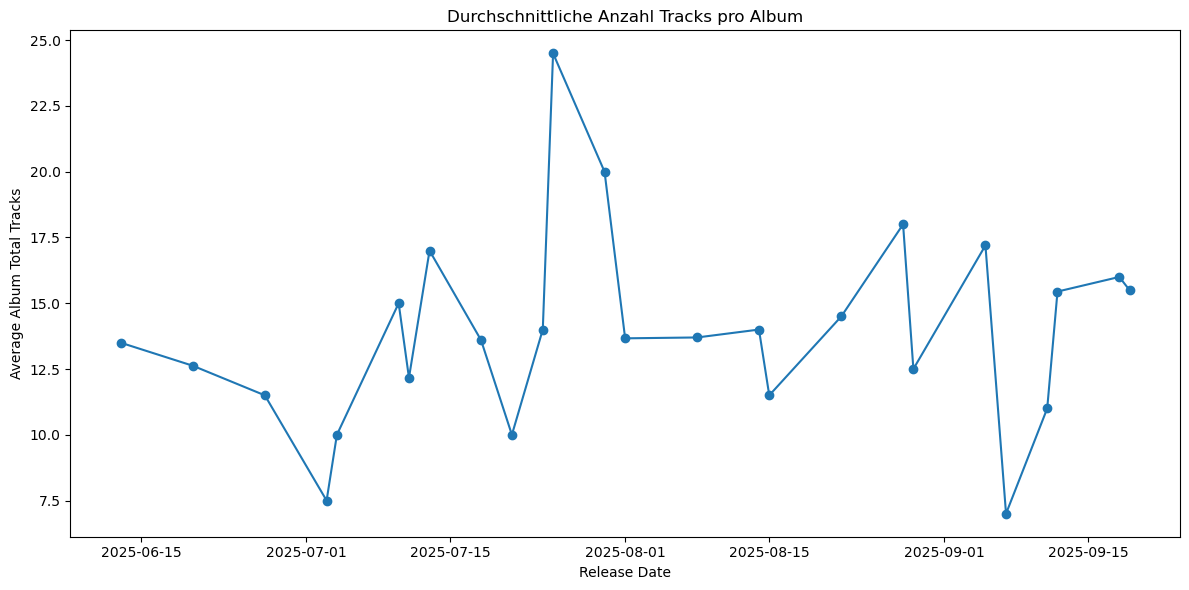

In [ ]:
## 
albums = df.drop_duplicates(subset=["album_id"]).copy()

albums['album_release_date'] = pd.to_datetime(albums['album_release_date'], errors='coerce')

avg_tracks_per_date = albums.groupby(albums['album_release_date'].dt.date)['album_total_tracks'].mean()

plt.figure(figsize=(12,6))
avg_tracks_per_date.plot(kind='line', marker='o')
plt.xlabel("Release Date")
plt.ylabel("Average Album Total Tracks")
plt.title("Durchschnittliche Anzahl Tracks pro Album")
plt.tight_layout()
plt.show()
